In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from itables import show
sns.set_style('darkgrid')

<IPython.core.display.Javascript object>

# Read datasets

In [3]:
data_campaign = pd.read_csv('anonymized_data/campaign_data.csv',)
data_coupon_to_item = pd.read_csv('anonymized_data/coupon_item_mapping.csv',)
data_demog = pd.read_csv('anonymized_data/customer_demographics.csv',)
data_transaction = pd.read_csv('anonymized_data/customer_transaction_data.csv',)
data_item = pd.read_csv("anonymized_data/item_data.csv")
data_train = pd.read_csv("anonymized_data/train.csv")
data_test = pd.read_csv("anonymized_data/test.csv")

# Popularity - Power Law

869    155
492    111
518     99
432     96
801     85
Name: coupon_id, dtype: int64

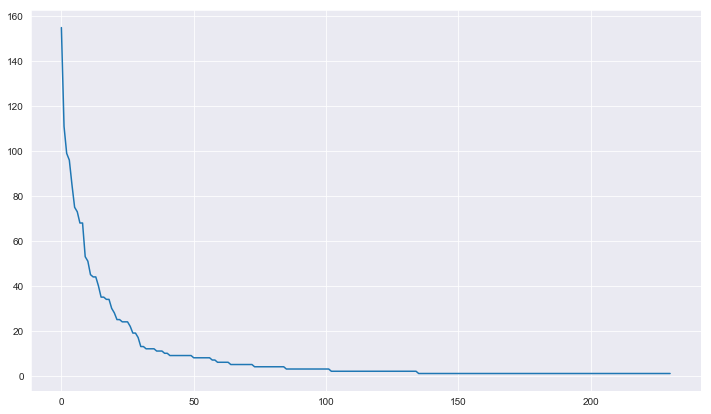

In [33]:
popular_coupons = data_train.loc[data_train["redemption_status"] == 1, "coupon_id"].value_counts()

display(popular_coupons.head())
plt.figure(figsize=(12, 7))
plt.plot(popular_coupons.values)

In [32]:
vc = data_train.groupby("coupon_id")["redemption_status"].value_counts().unstack()
vc_pct = vc.div(vc.sum(axis=1), axis=0)
vc_pct.columns = ["non-redeemed", "redeemed"]


print("Coupons redeemed more than 50%")
vc_pct[vc_pct["redeemed"] > 0.5].round(4)

Coupons redeemed more than 50%


,non-redeemed,redeemed
coupon_id,,
30,0.0286,0.9714
31,0.1667,0.8333
33,0.4521,0.5479
518,0.3694,0.6306
801,0.4848,0.5152


# Simple Feature Set
- all customer demographics
- Transaction related: average customer spend, item count, unique item count
- Campaign related: type, length
- Coupon & Item related: brand, brand type, category counts by customer, coupon discount stats

## Demographics

In [4]:
# number of children
data_demog["no_of_children"] = data_demog["no_of_children"].fillna(0)

# encode age range, family size
dict_le = {}
for col in ["age_range", "family_size", "no_of_children"]:
    le = LabelEncoder()
    data_demog[col] = le.fit_transform(data_demog[col].apply(str))
    dict_le[col] = le

In [5]:
# marital status
data_demog = data_demog.join(pd.get_dummies(data_demog["marital_status"], prefix="marital_status"))
data_demog = data_demog.drop(columns=["marital_status"])

In [6]:
for col in data_demog.columns.drop('customer_id'):
    print(data_demog[col].value_counts(dropna=False))

3    271
2    187
1    130
5     68
4     59
0     45
Name: age_range, dtype: int64
0    719
1     41
Name: rented, dtype: int64
1    303
0    248
2    104
4     57
3     48
Name: family_size, dtype: int64
0    538
1    107
3     60
2     55
Name: no_of_children, dtype: int64
5     187
4     165
6      88
3      70
2      68
1      59
8      37
7      32
9      29
12     10
10     10
11      5
Name: income_bracket, dtype: int64
0    443
1    317
Name: marital_status_Married, dtype: int64
0    646
1    114
Name: marital_status_Single, dtype: int64


In [7]:
for col in data_demog.columns.drop('customer_id'):
    data_demog[col] = data_demog[col].astype(np.int64)

## Transaction related
average customer spend, unique item count (per customer)

In [8]:
feat_ave_spend = data_transaction.groupby("customer_id")["selling_price"].mean().to_frame("customer_ave_spend")
feat_unique_items = data_transaction.groupby("customer_id")["item_id"].agg([("customer_unique_items", pd.Series.nunique)])
feat_transaction = feat_ave_spend.join(feat_unique_items, how='outer')

## Campaign Related
type, length (by campaign)

In [9]:
data_campaign["start_date"] = pd.to_datetime(data_campaign["start_date"], format='%d/%m/%y')
data_campaign["end_date"] = pd.to_datetime(data_campaign["end_date"], format='%d/%m/%y')
days_length = (data_campaign["end_date"] - data_campaign["start_date"]).dt.days

data_campaign["days_length"] = days_length
feat_campaign_length = data_campaign["days_length"]
feat_campaign_type_dummies = pd.get_dummies(data_campaign["campaign_type"], prefix="campaign_type")

In [10]:
feat_campaigns = feat_campaign_type_dummies.join(feat_campaign_length).join(data_campaign["campaign_id"])

## Item related
unique brand, brand type, category counts by customer

In [11]:
# brand, brand type, category
customer_to_item_coupon_merged = data_train.merge(data_coupon_to_item, how='left')\
                                            .merge(data_item, on = "item_id", how='left')

In [12]:
brand_counts = customer_to_item_coupon_merged.groupby("customer_id")["brand"].nunique().to_frame("brand_counts")
brand_type_counts = customer_to_item_coupon_merged.groupby(["customer_id", "brand_type"]).size().unstack().fillna(0)
brand_type_counts.columns = "brand_type_" + brand_type_counts.columns
category_type_counts = customer_to_item_coupon_merged.groupby(["customer_id", "category"]).size().unstack().fillna(0)
category_type_counts.columns = "category_type_" + category_type_counts.columns

feat_item = brand_counts.join(brand_type_counts).join(category_type_counts)

## Coupon Related
coupon discount stats, coupon item inclusions and categories

In [13]:
# merge train coupons to items to transactions to get discount
coupon_to_discount = data_coupon_to_item[data_coupon_to_item["coupon_id"].isin(data_train["coupon_id"])]\
                                                        .merge(data_item, on = "item_id", how='left')\
                                                        .merge(data_transaction[["item_id", "other_discount", "coupon_discount"]], on = "item_id", how='left')

In [14]:
show(coupon_to_discount.head())

,coupon_id,item_id,brand,brand_type,category,other_discount,coupon_discount


In [15]:
# coupon's item brand types and categories
# feat_item = brand_counts.join(brand_type_counts).join(category_type_counts)

coupon_brand_counts = coupon_to_discount.groupby("coupon_id")["brand"].nunique().to_frame("coupon_brand_counts")
coupon_brand_type_counts = coupon_to_discount.groupby(["coupon_id", "brand_type"]).size().unstack().fillna(0)
coupon_brand_type_counts.columns = "coupon_brand_type_" + coupon_brand_type_counts.columns

coupon_category_type_counts = coupon_to_discount.groupby(["coupon_id", "category"]).size().unstack().fillna(0)
coupon_category_type_counts.columns = "coupon_category_type_" + coupon_category_type_counts.columns

feat_coupon_item = coupon_brand_counts.join(coupon_brand_type_counts).join(coupon_category_type_counts)

In [16]:
feat_item_inclusions = coupon_to_discount.groupby("coupon_id")["item_id"].nunique().to_frame("number_of_coupon_items")
feat_other_discount_stats = coupon_to_discount.groupby("coupon_id")["other_discount"].agg(["mean", "min",])
feat_other_discount_stats.columns = "other_discount_stats_" + feat_other_discount_stats.columns

feat_coupon_discount_stats = coupon_to_discount.groupby("coupon_id")["coupon_discount"].agg(["mean", "min",])
feat_coupon_discount_stats.columns = "coupon_discount_stats_" + feat_coupon_discount_stats.columns

feat_coupon = feat_coupon_discount_stats.join(feat_other_discount_stats, how='left')

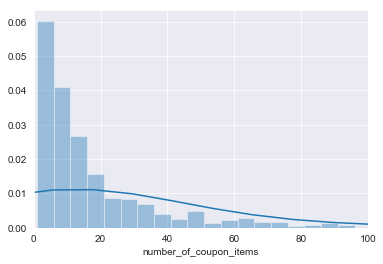

In [17]:
ax = sns.distplot(feat_item_inclusions["number_of_coupon_items"].clip(upper=1000), bins=200)

ax.set_xlim(0, 100);

# Join all features in train set

In [18]:
## demographics
# impute via mode
from sklearn.impute import SimpleImputer
demog_imputer = SimpleImputer(strategy="most_frequent")

data_train_demog = data_train.merge(data_demog, how='left')
data_train_demog = pd.DataFrame(demog_imputer.fit_transform(data_train_demog), columns=data_train_demog.columns)

In [19]:
## transaction
data_merged = data_train_demog.merge(feat_transaction.reset_index(), how='left')

## campaign
data_merged = data_merged.merge(feat_campaigns, how='left')

## item
data_merged = data_merged.merge(feat_item.reset_index(), how='left')

## coupon
data_merged = data_merged.merge(feat_coupon.reset_index(), how='left')

## coupon_to_item feat_coupon_item
data_merged = data_merged.merge(feat_coupon_item.reset_index(), how='left')

In [20]:
data_merged.shape

(77157, 61)

# EDA

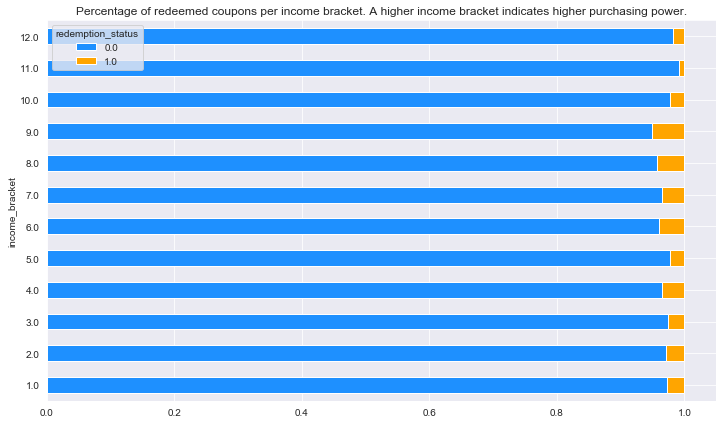

In [21]:
vc_redemption = data_merged.groupby("income_bracket")["redemption_status"].value_counts().unstack()

vc_redemption_pct = vc_redemption.div(vc_redemption.sum(axis=1), axis=0)

ax = plt.figure(figsize=(12, 7)).add_subplot(111)
vc_redemption_pct.plot.barh(stacked=True, color=['dodgerblue', 'orange'], ax=ax)
ax.set_title("Percentage of redeemed coupons per income bracket. A higher income bracket indicates higher purchasing power.");

In [22]:
data_train_to_item = data_train.merge(data_coupon_to_item).merge(data_item)

data_ct = data_train_to_item.groupby(["redemption_status", "brand_type"])["category"].value_counts().unstack(level=0)
data_ct_pct = data_ct.div(data_ct.sum(axis=1), axis=0)

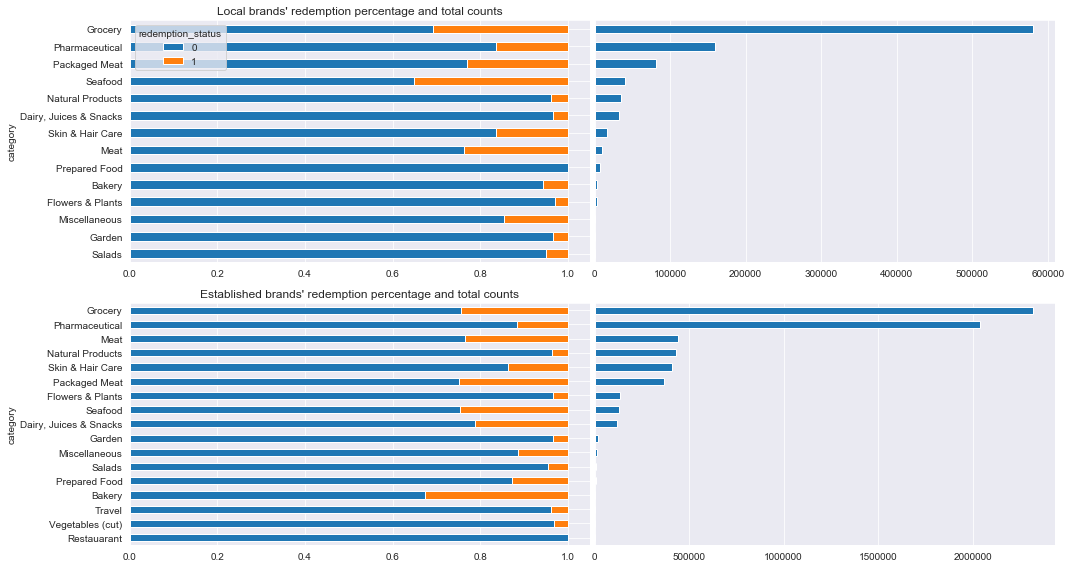

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# establish order
order = data_ct.sum(axis=1)["Local"].sort_values().index

# produce first pair plot: bar graph of all category types' local
data_ct_pct.xs("Local").loc[order].plot.barh(stacked=True, ax=axes[0][0])
data_ct.sum(axis=1).xs("Local").loc[order].plot.barh(stacked=True, ax=axes[0][1])
axes[0][0].set_title("Local brands' redemption percentage and total counts")

# establish order
order = data_ct.sum(axis=1)["Established"].sort_values().index

# produce second pair plot: bar graph of all category types' established
data_ct_pct.xs("Established").loc[order].plot.barh(stacked=True, ax=axes[1][0])
data_ct.sum(axis=1).xs("Established").loc[order].plot.barh(stacked=True, ax=axes[1][1])
axes[1][0].set_title("Established brands' redemption percentage and total counts")

fig.tight_layout()
fig.subplots_adjust(wspace=0.01)

axes[0][1].set_ylabel("")
axes[0][1].set_yticks([])
axes[1][1].set_ylabel("")
axes[1][1].set_yticks([])
axes[1][0].get_legend().remove();

In [24]:
data_tn = data_train_to_item.merge(data_transaction, on=["customer_id", "item_id"])
redeemed = data_tn[data_tn["redemption_status"] == 1].sample(10000)
nonredeemed = data_tn[data_tn["redemption_status"] == 0].sample(10000)

c:\users\valeridm\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'name'
  s)
c:\users\valeridm\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'name'
  s)


(0, 400)

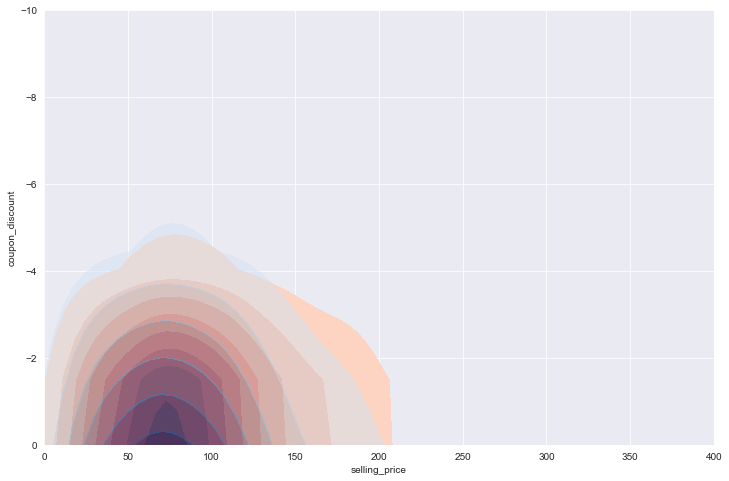

In [25]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
# clip the values for outliers
sns.kdeplot(redeemed["selling_price"].clip(upper=redeemed["selling_price"].quantile(0.99)), 
            redeemed.coupon_discount.clip(upper=redeemed.coupon_discount.quantile(0.99)),
                cmap="Reds", shade=True, shade_lowest=False, ax=ax, name="redeemed")
sns.kdeplot(nonredeemed["selling_price"].clip(upper=nonredeemed["selling_price"].quantile(0.99)),
            nonredeemed.coupon_discount.clip(upper=nonredeemed.coupon_discount.quantile(0.99)), 
                cmap="Blues", shade=True, shade_lowest=False, ax=ax, alpha=0.5, name="non redeemed")

# ax.get_legend().set_legend()

ax.set_ylim((0, -10))
ax.set_xlim((0, 400))

In [26]:
import scipy
# customer spend, t-test for different means
customer_spend_stats = data_merged.groupby("redemption_status")["customer_ave_spend"].describe()

res = scipy.stats.ttest_ind_from_stats(customer_spend_stats.iloc[0]["mean"], customer_spend_stats.iloc[0]["std"],
                                     customer_spend_stats.iloc[0]["count"],
                                 customer_spend_stats.iloc[1]["mean"], customer_spend_stats.iloc[1]["std"],
                                    customer_spend_stats.iloc[1]["count"])
print(res)
print("Looks like a non-significant difference, although those pairs that have redeemed coupons have a higher customer spend.")

Ttest_indResult(statistic=-1.5827648478914138, pvalue=0.11347917031822048)
Looks like a non-significant difference, although those pairs that have redeemed coupons have a higher customer spend.


In [27]:
# making the discount values positive for easier interpretation
data_merged["coupon_discount_stats_mean"] = data_merged["coupon_discount_stats_mean"].abs()
stats_test = data_merged.groupby("redemption_status")["coupon_discount_stats_mean"].describe()

res = scipy.stats.ttest_ind_from_stats(stats_test.iloc[0]["mean"], stats_test.iloc[0]["std"],
                                     stats_test.iloc[0]["count"],
                                 stats_test.iloc[1]["mean"], stats_test.iloc[1]["std"],
                                    stats_test.iloc[1]["count"])
display(stats_test)
print(res)
print("Looks like a significant difference. And non-intuitively, the non-redeemed coupons have a higher mean.")
print("A coupon does have many items in its basket. A high average may indicate intimidating items, after all.")

,count,mean,std,min,25%,50%,75%,max
redemption_status,,,,,,,,
0.0,75041.0,1.927542,5.286206,0.000000,0.000000,0.562421,1.838876,71.240
1.0,2116.0,1.507764,2.168163,0.022189,0.552739,0.708865,1.926840,41.248


Ttest_indResult(statistic=3.6442136376438223, pvalue=0.00026838643300285565)
Looks like a significant difference. And non-intuitively, the non-redeemed coupons have a higher mean.
A coupon does have many items in its basket. A high average may indicate intimidating items, after all.


In [28]:
# making the discount values positive for easier interpretation
data_merged["coupon_discount_stats_min"] = data_merged["coupon_discount_stats_min"].abs()
stats_test = data_merged.groupby("redemption_status")["coupon_discount_stats_min"].describe()

res = scipy.stats.ttest_ind_from_stats(stats_test.iloc[0]["mean"], stats_test.iloc[0]["std"],
                                     stats_test.iloc[0]["count"],
                                 stats_test.iloc[1]["mean"], stats_test.iloc[1]["std"],
                                    stats_test.iloc[1]["count"])
display(stats_test)
print(res)
print("Looks like a significant difference. As expected, redeemed triplets have a higher baseline. Larger discounts!")

,count,mean,std,min,25%,50%,75%,max
redemption_status,,,,,,,,
0.0,75041.0,66.916175,150.938735,0.00,0.00,35.62,71.24,1992.23
1.0,2116.0,189.182580,339.092917,12.47,59.49,80.14,142.12,1992.23


Ttest_indResult(statistic=-34.86429357551129, pvalue=2.975524684207573e-264)
Looks like a significant difference. As expected, redeemed triplets have a higher baseline. Larger discounts!


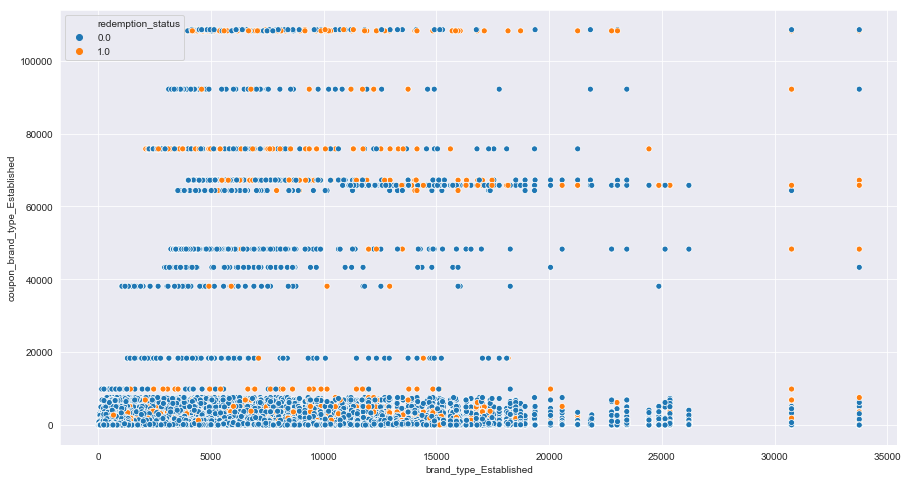

In [29]:
ax = plt.figure(figsize=(15,8)).add_subplot(111)
sns.scatterplot(x="brand_type_Established", y="coupon_brand_type_Established", 
                hue="redemption_status", data=data_merged, ax=ax)